In [2]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Things that you need to have in your head 



In [11]:
# Configure load path
import pickle
import pandas as pd
import os
import requests
from urllib.parse import urlencode
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, r2_score, d2_absolute_error_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
import xgboost as xgb
from dateutil.relativedelta import relativedelta
from tqdm import tqdm, tqdm_notebook
import numpy as np
import random
import json
from datetime import datetime, timedelta
import re
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.tree    import DecisionTreeRegressor
from sklearn.tree    import DecisionTreeClassifier
import itertools

os.chdir("C:/Users/Win11/Documents/Repos/Acorn-Casino-PLTV/")

bs_token = 'S7Fek4qridIxY1sUfYUyOl0rLak1Eedeg0TTCWHzUHqIFuUGN07xZtd41ZCp2UvE'  # Token Bingo Arena
host = 'td.winnerstudio.vip'

# Path Thinking Engine tables
tables_path = 'pltv_lucky_accorn_ios_tables.py'
start_date = '2023-08-31'
end_date = (datetime.now() - timedelta(days = 120)).strftime('%Y-%m-%d')
client_name = 'ios'

# Load queries from remote python script (This needs to be perfect).  Overall, you might want to have the lsit here
exec(open(tables_path).read())
tables = locals().get('tables')


# Data pull

### Version all 

In [13]:
def load_data(bs_token, host):

    def pull_data(sql_script, bs_token, host):

        data = {
            'token':          bs_token,
            'format':         'json_object',
            'timeoutSeconds': 20000,
            'sql':            sql_script
        }

        data = str(urlencode(data))
        response = requests.post(f'http://{host}:8992/querySql?{data}', timeout = 1000000)

        # Sample list of JSON strings
        json_list = response.text.split('\n')[1:]

        # Convert JSON strings to dictionaries
        dict_list = []
        for json_str in json_list:
            try:
                dict_list.append(json.loads(json_str))
            except json.JSONDecodeError as e:
                print(f"Error parsing JSON: {e}")

        # Create a pandas DataFrame
        data = pd.DataFrame(dict_list).sort_index(axis = 1)
        print('+1')
        # Display the DataFrame
        return data

    # Load the first data using USER_PAYMENT, and then iteatevely join the remaining data for trainning
    df = pull_data(tables[0], bs_token, host)
    print(df.columns)
    for i in range(1, len(tables)):
        new_data = pull_data(tables[i], bs_token, host)
        print(new_data.head(2))
        df = df.merge(new_data, on = '#account_id')

    df['#account_id'] = df['#account_id'].astype(str) # One of them might not be recommended since it is already a string
    df['register_time'] = pd.to_datetime(df['register_time'], errors = 'coerce')
    return df

# Create df by loading information and joining on account_id
df = load_data(bs_token, host)
df.shape

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
+1
Index(['#account_id', 'cp1', 'cp3', 'cp7', 'p1', 'p10', 'p100', 'p105', 'p11',
       'p112', 'p119', 'p12', 'p126', 'p13', 'p133', 'p14', 'p15', 'p16',
       'p17', 'p18', 'p19', 'p2', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25',
       'p26', 'p27', 'p28', 'p3', 'p35', 'p4', 'p42', 'p49', 'p5', 'p56', 'p6',
       'p63', 'p7', 'p70', 'p77', 'p8', 'p84', 'p9', 'p91', 'p98', 'ph1',
       'ph6', 'register_time'],
      dtype='object')
Error parsing JSON: Expecting value: line 1 column 1 (char 0)
+1
  #account_id   w1  w10  w100  w105  w11  w112  w119  w12  w126  ...  w56  \
0       84008  0.0  0.0   0.0   0.0  0.0   0.0   0.0  0.0   0.0  ...  0.0   
1       84294  0.0  0.0   0.0   0.0  0.0   0.0   0.0  0.0   0.0  ...  0.0   

   w63   w7  w70  w77   w8  w84   w9  w91  w98  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[2 rows x 41 columns]
Error parsing JSON: Expecting v

(27954, 135)

In [14]:
df['#account_id'] = df['#account_id'].astype(str)
df['register_time'] = pd.to_datetime(df['register_time'], errors = 'coerce')
df['date'] = df['register_time'].apply(lambda x: int(x.strftime('%Y%m%d')))

df = df.fillna(0)

In [15]:
# Calculate differences
day_columns = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7']
for i in range(len(day_columns) - 1, 0, -1):
    df[f'{day_columns[i]}_diff'] = df[day_columns[i]] - df[day_columns[i - 1]]

In [20]:
diff_columns_names = [col for col in df.columns if col.endswith('_diff')]
payment_cols = diff_columns_names + ['w7'] + ['p1'] + ['ph6'] + ['cp7'] + ['cp1'] + ['d7_28_increment']
df['d7_28_increment'] = df['p28'] - df['w28'] + df['ad28'] - (df['p7'] - df['w7'] + df['ad7'])

In [21]:
integers_list = list(range(7, 28))
incremented_numbers = [str(number) for number in range(28, 36, 7)]
predictors_days_input = predictors_days = [str(integer) for integer in integers_list] + incremented_numbers

# Available dates as target (I am considering adding more values, above and below, maybe up to two on each side)
response_days_input = response_days = ["14", "28", "56", "63", "70", "77", "84", "91", "98", "100", "105", "112", "119", "126", "133"]

### Calculation validation

This step maybe I will jump it for higher speed

In [ ]:
## Load API


In [ ]:
## Give me payment: 


In [ ]:
## Give me withdrawal: 


In [ ]:
## Give me ad revenue:


# Find 

In [22]:
# Pipeline functions definition 

def create_huber(alpha, epsi, cols): 
    
    columns = cols
    preprocessor = ColumnTransformer(
        transformers = [
            ('scaler', StandardScaler(), columns)
        ],
        remainder='passthrough'
    )
    
    # Create the pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', HuberRegressor(fit_intercept=True, epsilon=epsi, alpha=alpha, warm_start=False, max_iter=1200))
    ])

    return pipe

def all_feature_enginerring(data, response):

    """
    This is better to create before and the just utilise it in whatever model
        - Notice what you're doing with withdrawal day 100 (I am not so interested in withdrawal but it is fine)
    """
    
    # Payment predictor 
    xgbt = xgb.XGBClassifier(min_samples_leaf = 500)
    xgbt.fit(data, (response > 0.01).astype(int))
    data['payer_model'] = xgbt.predict_proba(data)[:, 1]

    # Outlier predictor 
    dt = DecisionTreeClassifier(random_state = 42, min_samples_leaf = 1500)
    dt.fit(data, (response > 300).astype(int))
    data['oulier_model'] = dt.predict_proba(data)[:, 1]

    # Inclusion of interpolation 
    column_list = ['p7_diff', 'p3_diff', 'p1', 'w7']
    column_combinations = list(itertools.combinations(column_list, 2))

    for pair in column_combinations:
        column1, column2 = pair
        new_column_name = f"{column1}_times_{column2}"
        data[new_column_name] = data[column1] * data[column2]  # Example: Multiply values of two columns

    # Some divisions 
    # data['payment_growth'] = data['p7_diff'] / data['money_status_d7']

    return data


In [23]:
validation_sets = 3
df['validation_set_id'] = pd.qcut(df['date'].values, validation_sets)

df.groupby('validation_set_id').size()


validation_set_id
(20230830.999, 20230909.0]    9760
(20230909.0, 20230918.0]      9537
(20230918.0, 20230928.0]      8657
dtype: int64

In [24]:

model_results = []
all_model_results = []
alphas = [0.01, 0.05, 0.02, 0.05, 0.1] 
epsils = [1.2, 1.3, 1.5, 1.7, 2, 2.5] 

# for train_index, test_index in splits:
for date_group in df['validation_set_id'].unique():

    train_data =  df[df['validation_set_id'] != date_group][payment_cols]
    test_data =  df[df['validation_set_id'] == date_group][payment_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'd7_28_increment']), train_data[f'd7_28_increment']
    X_test, y_test = test_data.drop(columns = [f'd7_28_increment']), test_data[f'd7_28_increment']

    old_cols = X_train.copy().columns
    X_train = all_feature_enginerring(X_train, y_train)
    X_test = all_feature_enginerring(X_test, y_test)

    for alpha in alphas: 

        for epsi in epsils: 
        
            for cols in [old_cols, X_train.columns]:
                
                print(alpha, epsi, cols)
                # Full trainning and testing 
                model = create_huber(alpha, epsi, cols)

                try: 
                    model.fit(X_train[cols], y_train)
                    predictions = model.predict(X_test[cols])
                    mae = mean_absolute_error(y_test, predictions)
                    r2 = r2_score(y_test, predictions)

                except: 
                    model = np.nan
                    predictions = np.nan
                    mae = np.nan
                    r2 = np.nanZ
                
                # Save the model into dictionary (Response, day, mo...)
                model_result = pd.DataFrame({
                    'Iteration': [str(alpha) + ' - ' + str(epsi) + ' - ' + str(len(cols))]
                    , 'Test at': [date_group]
                    , 'Model': [model]
                    , 'mae': [mae]
                    , 'r2': [r2]
                    , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
                })

                model_results.append(model_result)
    
    all_model_results.extend(model_results)


[10:44:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf" } are not used.

[10:44:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf" } are not used.

0.01 1.2 Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7',
       'p1', 'ph6', 'cp7', 'cp1'],
      dtype='object')
0.01 1.2 Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7',
       'p1', 'ph6', 'cp7', 'cp1', 'payer_model', 'oulier_model',
       'p7_diff_times_p3_diff', 'p7_diff_times_p1', 'p7_diff_times_w7',
       'p3_diff_times_p1', 'p3_diff_times_w7', 'p1_times_w7'],
      dtype='object')
0.01 1.3 Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7',
       'p1', 'ph6', 'cp7', 'cp1'],
      dtyp

In [26]:
all_model_results = pd.concat(all_model_results, ignore_index = True)#.sort_values(by = ['Available day', 'Model'])


In [27]:
Test_at = all_model_results['Test at'].max()
all_model_results[all_model_results['Test at'] == Test_at].sort_values(by = 'mae').head(10)

,Iteration,Test at,Model,mae,r2,rel_mae
357,0.1 - 2 - 19,"(20230918.0, 20230928.0]","(ColumnTransformer(remainder='passthrough',\n ...",2.016978,0.073349,0.295763
309,0.01 - 2 - 19,"(20230918.0, 20230928.0]","(ColumnTransformer(remainder='passthrough',\n ...",2.017703,0.074246,0.295510
305,0.01 - 1.5 - 19,"(20230918.0, 20230928.0]","(ColumnTransformer(remainder='passthrough',\n ...",2.020027,0.072145,0.294699
327,0.02 - 1.3 - 19,"(20230918.0, 20230928.0]","(ColumnTransformer(remainder='passthrough',\n ...",2.022442,0.076009,0.293855
307,0.01 - 1.7 - 19,"(20230918.0, 20230928.0]","(ColumnTransformer(remainder='passthrough',\n ...",2.023815,0.084149,0.293376
301,0.01 - 1.2 - 19,"(20230918.0, 20230928.0]","(ColumnTransformer(remainder='passthrough',\n ...",2.024988,0.076441,0.292967
349,0.1 - 1.2 - 19,"(20230918.0, 20230928.0]","(ColumnTransformer(remainder='passthrough',\n ...",2.025712,0.075692,0.292714
319,0.05 - 1.7 - 19,"(20230918.0, 20230928.0]","(ColumnTransformer(remainder='passthrough',\n ...",2.027378,0.078327,0.292132
343,0.05 - 1.7 - 19,"(20230918.0, 20230928.0]","(ColumnTransformer(remainder='passthrough',\n ...",2.027378,0.078327,0.292132
325,0.02 - 1.2 - 19,"(20230918.0, 20230928.0]","(ColumnTransformer(remainder='passthrough',\n ...",2.028130,0.078020,0.291870


In [28]:
amrgb = all_model_results.groupby('Iteration')[['mae', 'r2', 'rel_mae']].mean().sort_values(by = 'rel_mae', ascending = False).reset_index(drop = False)
amrgb.head(5)


,Iteration,mae,r2,rel_mae
0,0.02 - 1.2 - 11,1.773492,0.169203,0.359019
1,0.01 - 2.5 - 11,1.774923,0.179027,0.358596
2,0.1 - 1.7 - 11,1.775569,0.179460,0.358366
3,0.02 - 2 - 11,1.775773,0.181025,0.358284
4,0.01 - 1.2 - 11,1.776227,0.151905,0.358065
5,0.05 - 1.7 - 11,1.777922,0.177565,0.357499
6,0.1 - 2 - 11,1.778944,0.178309,0.357159
7,0.05 - 2 - 11,1.782697,0.165209,0.355800
8,0.1 - 1.5 - 11,1.782855,0.171749,0.355744
9,0.02 - 1.5 - 11,1.783150,0.173855,0.355634


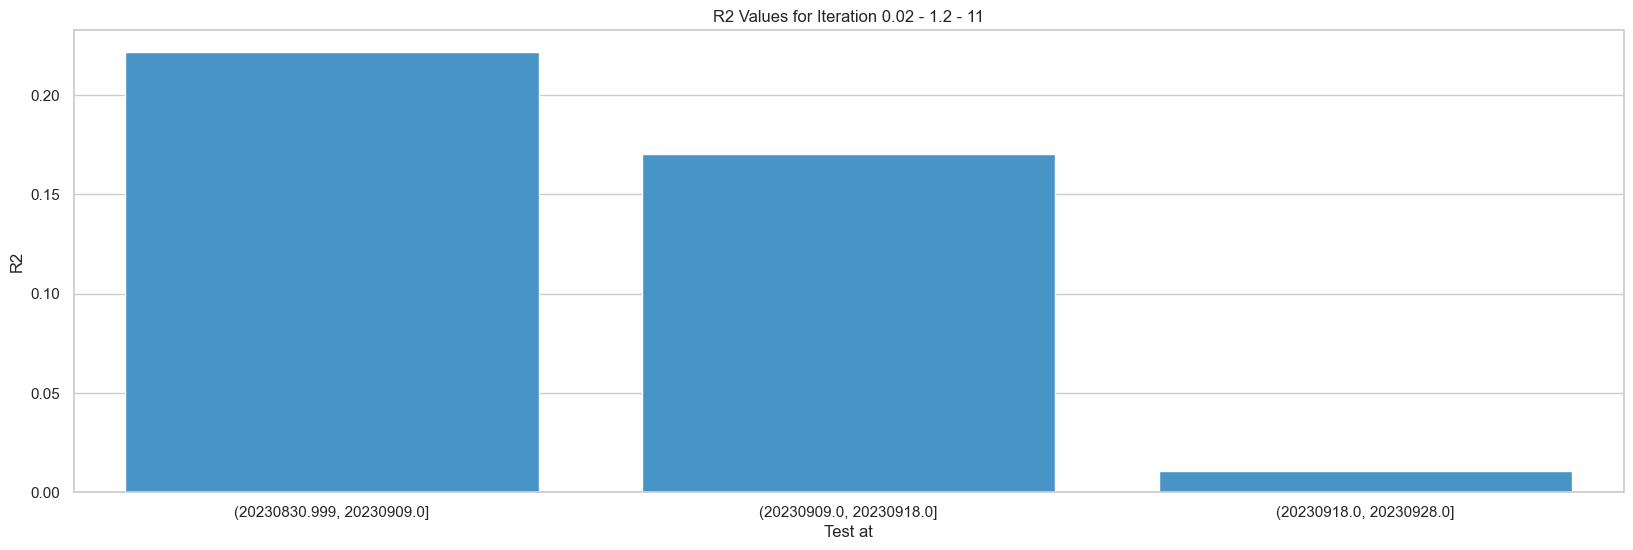

In [30]:
# yEs you could do a deeper check here. 

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'
# Replace 'your_iteration_value' with the specific iteration you are interested in
iteration_value = amrgb['Iteration'].values[0] #'0.05 - 1.5 - 11'
# iteration_value = '0.05 - 2 - 19'
subset_df = all_model_results[all_model_results['Iteration'] == iteration_value]

# Set the seaborn style to a more professional one
sns.set(style="whitegrid")

# Create the Seaborn barplot for R2
plt.figure(figsize=(20, 6))

# Plotting R2 in a professional color
sns.barplot(x='Test at', y='r2', data=subset_df, color='#3498db')  # Use a professional blue color

plt.title(f'R2 Values for Iteration {iteration_value}')
plt.xlabel('Test at')
plt.ylabel('R2')
plt.show()


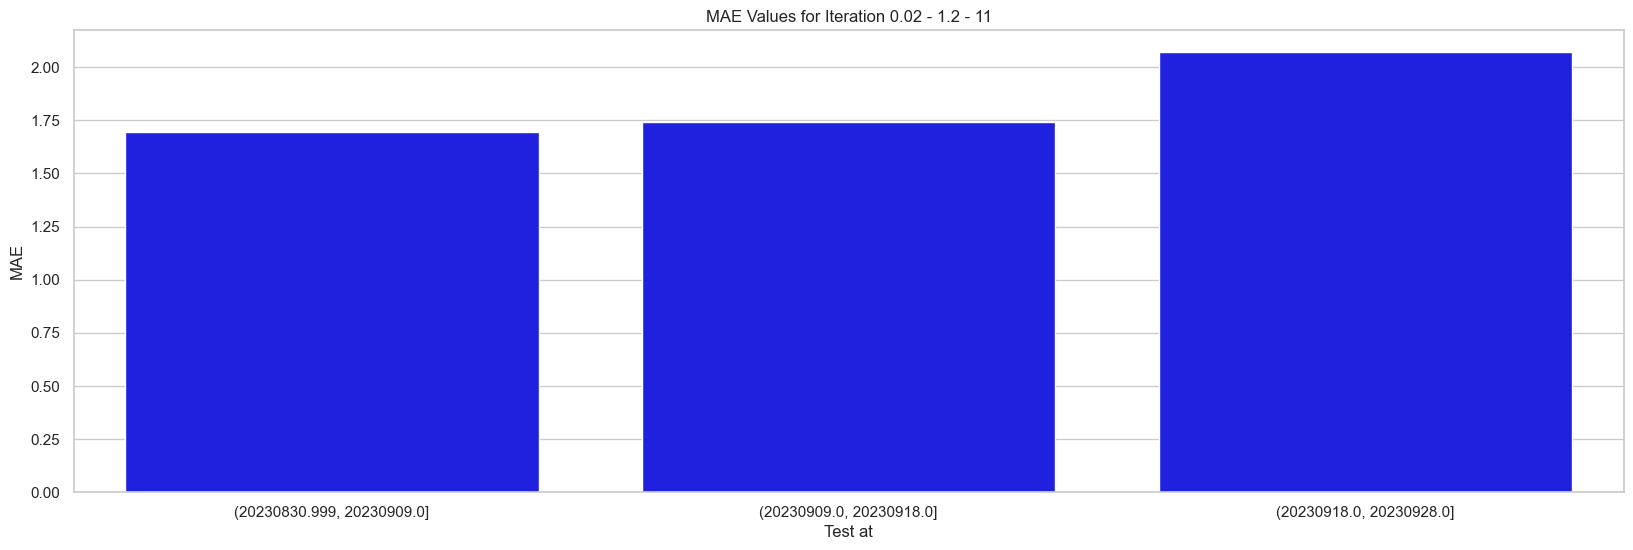

In [32]:
# Set the seaborn style to a more professional one
sns.set(style="whitegrid")

# Create the Seaborn barplot for R2
plt.figure(figsize=(20, 6))

# Plotting R2 in blue
sns.barplot(x='Test at', y='mae', data=subset_df, color='blue')

plt.title(f'MAE Values for Iteration {iteration_value}')
plt.xlabel('Test at')
plt.ylabel('MAE')
plt.show()

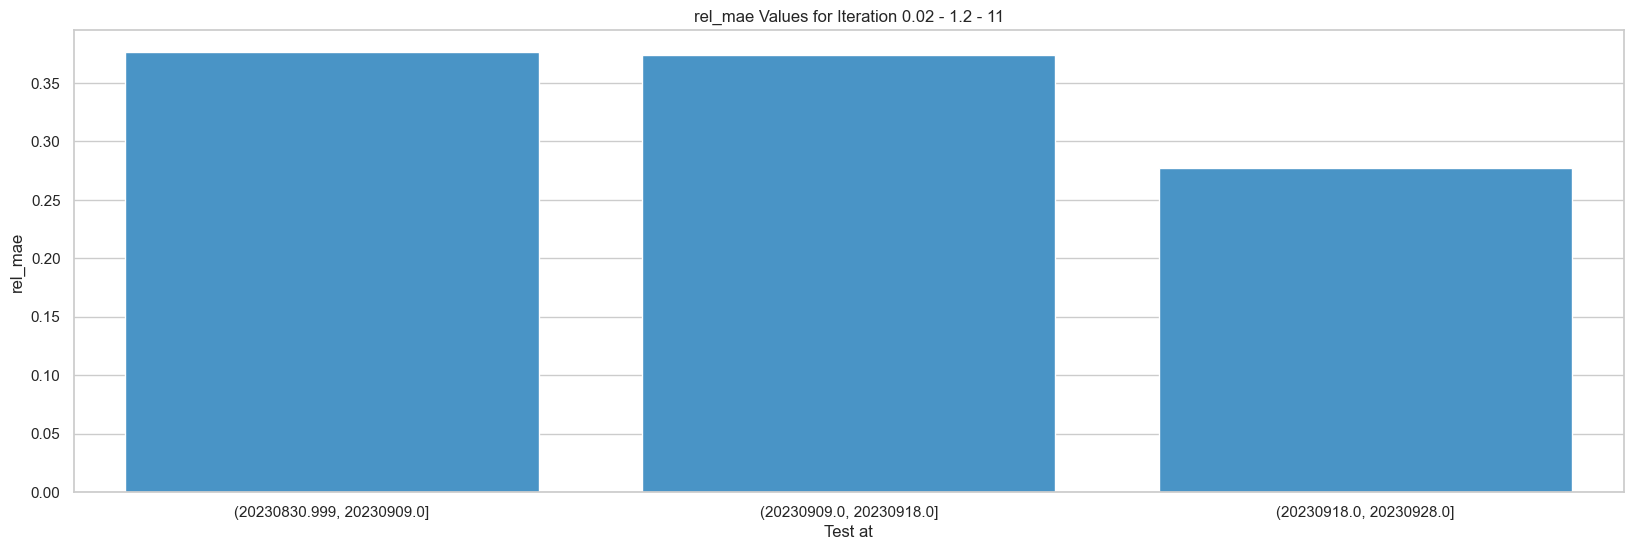

In [33]:
# Set the seaborn style to a more professional one
sns.set(style="whitegrid")

# Create the Seaborn barplot for R2
plt.figure(figsize=(20, 6))

# Plotting R2 in a professional color
sns.barplot(x='Test at', y='rel_mae', data=subset_df, color='#3498db')  # Use a professional blue color

plt.title(f'rel_mae Values for Iteration {iteration_value}')
plt.xlabel('Test at')
plt.ylabel('rel_mae')
plt.show()

In [34]:
model_value = all_model_results.loc[all_model_results['Iteration'] == iteration_value, 'Model'].iloc[0]
df_plus = all_feature_enginerring(df[payment_cols], df[f'd7_28_increment']).sample(3000)

cols_to_append = [
    'roas_d7_times_installs_difference',
    'withdrawn_ratio_times_installs_difference',
    'withdrawn_ratio_times_pred_8_28',
    'roas_d7_times_pred_8_28',
    'roas_d7_times_withdrawn_ratio',
    'pred_8_28_times_installs_difference'
]

subnormal = [col for col in old_cols if col != 'Installs']
# subnormal.extend(cols_to_append)
subnormal

predictions = model_value.predict(df_plus[subnormal])

[10:52:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf" } are not used.



In [35]:
import pandas as pd
import plotly.express as px

# Assuming reset_df is your DataFrame
pdf = pd.DataFrame({'y_test': df_plus[f'd7_28_increment'].values, 'predictions': predictions})

# Create a scatter plot with color-coded categories
fig = px.scatter(pdf, x = 'predictions', y = 'y_test', title = 'Association Actuals vs Predictions', trendline='ols',
                 labels = {'predictions': 'X-axis Label', 'y_test': 'Y-axis Label'},
                 template = 'plotly_dark',  # Choose a dark template for a professional look
                 hover_data = ['predictions', 'y_test'],  # Additional information on hover
                #  marginal_x = 'box',  # Display box plot on the x-axis
                #  marginal_y = 'violin'  # Display violin plot on the y-axis
                 )

# Customize the layout
fig.update_layout(
    width = 1500,  # Set the width in pixels
    height = 1000,  # Set the height in pixels
    xaxis = dict(title_text = 'Predicted'),
    yaxis = dict(title_text = 'Actual user revenue'),
    legend = dict(title = 'Legend Title'),
    showlegend = True
)

# Show the plot

# Fit to all combinations 

In [36]:
# old_cols = old_cols.to_list()
def create_huber(alpha, epsi, cols): 
    
    columns = cols
    preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', StandardScaler(), columns)
        ],
        remainder='passthrough'
    )
    
    # Create the pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', HuberRegressor(alpha = alpha, epsilon = epsi, max_iter = 1000))
    ])

    return pipe

In [37]:
max_date = df['register_time'].max()
df['days_since_install'] = (max_date - df['register_time']).dt.total_seconds() / (60 * 60 * 24) # Needed? Yes
df['days_since_install']

0        28.0
1        25.0
2        25.0
3        25.0
4        24.0
         ... 
27949    25.0
27950    23.0
27951    23.0
27952    23.0
27953    22.0
Name: days_since_install, Length: 27954, dtype: float64

In [38]:
# List of day columns
day_columns = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7']

# Calculate differences
for i in range(len(day_columns) - 1, 0, -1):
    df[f'{day_columns[i]}_diff'] = df[day_columns[i]] - df[day_columns[i - 1]]
    

In [39]:
winner_cols = ['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'p1', 'ph6', 'cp7', 'cp1']


In [48]:
a = float(iteration_value.split(' - ')[0])
e = float(iteration_value.split(' - ')[1])
payback_predictive_system = []

for y_day in tqdm(response_days):

  for x_day in predictors_days:

    if int(y_day) > int(x_day):

      # Make the response (You need to work out how to get a bigger response):
      # df['y'] = df[f'p{y_day}'] + df[f'ad{y_day}'] - df[f'w{y_day}'] - (df[f'p{x_day}'] + df[f'ad{x_day}'] - df[f'w{x_day}'])
      df['y'] = df[f'p{y_day}'] - df[f'w{y_day}'] - (df[f'p{x_day}'] - df[f'w{x_day}'])
      y = df[df['days_since_install'] <= (int(y_day) - 1)]['y']
      del df['y']

      # Make the regressors

      ## I. Get the differentiations (The basics you should have obtained beforehand. So only the last one is okay)
      df[f'p_last_diff_7_{x_day}'] = df[f'p{x_day}'] - df[f'p7']
      df[f'w_last_diff_7_{x_day}'] = df[f'w{x_day}'] - df[f'w7']
      # df[f'ad_last_diff'] = df[f'ad{x_day}'] - df[f'ad7']
      
      selected_columns = winner_cols + [f'p_last_diff_7_{x_day}'] + [f'w_last_diff_7_{x_day}'] #+ [f'ad_last_diff']
      X = df[df['days_since_install'] <= (int(y_day) - 1)][selected_columns]
      model = create_huber(a, e, selected_columns)
      model.fit(X, y)

      # Save the model into dictionary (Response, day, model)
      payback = pd.DataFrame({
              'Available day': [x_day]
              , 'Target day': [y_day]
              , 'Model': [model]
              , 'Columns': [X.columns]
              })

      payback_predictive_system.append(payback)

model_dict = pd.concat(payback_predictive_system, ignore_index = True)

100%|██████████| 15/15 [04:13<00:00, 16.91s/it]


In [ ]:
with open('acorn_ios_ptlv_dictionary_2024_jan.pkl', 'wb') as file:
    pickle.dump(model_dict, file)